# Model Experimentation

## Notebook Setup

In [0]:
%pip install timezonefinder
%pip install tzfpy
%pip install "mlflow>=1.25.0"

Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached cffi-1.15.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (441 kB)
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Created wheel for timezonefinder: filename=timezonefinder-6.1.8-cp39-cp39-manylinux_2_31_x86_64.whl size=45919981 sha256=a3283201e4f979ad6718a2d76542ca52f9dcd0a5e4d1d7e5062ec98db9c821a9
  Stored in directory: /home/spark-05f6ab32-2bbe-4322-a894-8b/.cache/pip/wheels/e6/43/c7/911bd3351ddf33fe74a51d98c51a2e6563ab046b77f37eeef7
Successfully built timezonefinder
  Attempting uninstall: setuptools
    Found existing installation: setuptools 58.0.4
    Not uninstalling setuptools at /usr/local/lib/

In [0]:
# General 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sys
from statistics import mean
import itertools
import mlflow.spark
from sklearn.metrics import roc_curve

# PySpark 
from pyspark.sql.functions import col,isnan,when,count
from pyspark.sql.functions import regexp_replace

# SQL Functions
from pyspark.sql import functions as f
from pyspark.sql.functions import monotonically_increasing_id, to_timestamp, to_utc_timestamp, to_date
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank, first, dense_rank
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType, DecimalType
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseMatrix, Vectors, DenseVector
from pyspark.sql.functions import row_number

# ML
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier, LogisticRegressionModel, DecisionTreeClassificationModel, RandomForestClassificationModel, MultilayerPerceptronClassificationModel, MultilayerPerceptronClassificationModel
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, LinearRegressionModel
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.functions import vector_to_array

# Misc 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from timezonefinder import TimezoneFinder
from tzfpy import get_tz

In [0]:
# Display and define where mids-w261 is located
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

# Inspect the Mount's Final Project folder 
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

In [0]:
blob_container = "housestark" # The name of your container created in https://portal.azure.com
storage_account = "neilp" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261_s1g4" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261_s1g4_key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

In [0]:
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
df_full = spark.read.parquet(f"{blob_url}/df_main_fullClean")

## Helper Functions

In [0]:
# Function to create pipeline
def create_pipeline(df, inputCols_cat, inputCols_cont):
  """Creates a feature engineering pipeline for modeling 
  Args:
    inputCols_cat (list): list of categorical input cols
    inputCols_cont (list): list of continuous input cols 
  
  Returns: 
    pipeline (Pipeline): MLlib pipeline with stages  
  """
  
  # String Indexer
  inputCols_categorical_indexed = [f'{i}_index' for i in inputCols_cat]
  string_indexer = StringIndexer(inputCols = inputCols_cat, 
                                 outputCols = inputCols_categorical_indexed).setHandleInvalid('keep')

  # One Hot Encoder  
  inputCols_categorical_encoded = [f'{i}_encoded' for i in inputCols_categorical_indexed]
  one_hot_encoder = OneHotEncoder(inputCols = inputCols_categorical_indexed, 
                                  outputCols = inputCols_categorical_encoded)

  # Vector Assembler (Categorical)
  assembler_cat = VectorAssembler(inputCols = inputCols_categorical_encoded, 
                              outputCol = 'features_cat').setHandleInvalid('keep')
  
  # Vector Assembler (Continuous)
  assembler_cont = VectorAssembler(inputCols = inputCols_cont, 
                              outputCol = 'features_cont').setHandleInvalid('keep')

  # Pipeline
  return Pipeline().setStages([string_indexer, one_hot_encoder, assembler_cat, assembler_cont])

In [0]:
def impute_and_scale_features(df):
  
  # Impute data 
  imputed_df, imputed_cols = preModeling_dataEdit(df)

  # Vector Assembler (Continuous) 
  assembler_cont = VectorAssembler(inputCols = ['features_cont'] + imputed_cols, 
                              outputCol = 'features_cont_all').setHandleInvalid('keep')

  # Standard Scaler 
  scaler = StandardScaler(inputCol = 'features_cont_all',
                          outputCol = 'features_scaled',
                          withMean = True, withStd = True)
  
  # Vector Assembler (Continuous + Categorical) 
  assembler_all = VectorAssembler(inputCols = ['features_scaled', 'features_cat'], 
                              outputCol = 'features_all').setHandleInvalid('keep')

  pipeline = Pipeline().setStages([assembler_cont, scaler, assembler_all])

  # Create features_scaled for all dfs
  pipeline_df = pipeline.fit(imputed_df).transform(imputed_df) 
  
  return  pipeline_df

In [0]:
def preModeling_dataEdit(df):
  '''
  Input: df that has already gone through the final join, cleaning, and feature engineering
  Output: df that includes null imputing and # and % of flights (by tail number) that were delayed and cancelled in the past 90 days --> these depend on window functions, as such they need to be done right after the data is split for modelling and not during feature engineering phase
  '''
  
  ### FINAL CLEANING 
  # Remove rows with null scheduled_departure_UTC because these are rows without a proper timezone (timezonefinder could not find)
  df = df.na.drop(subset=["scheduled_departure_UTC"])
  dropCols = ['TAXI_IN', 'TAXI_OUT']
  df = df.drop(*dropCols) 

  
  ### FINAL FEATURE ADDITIONS
  ## GET NUMBER & PERCENTAGE OF TIMES A PLANE (BY TAIL NUMBER) HAS BEEN DELAYED OR CANCELLED IN THE PAST 3 MONTHS (2 COLUMNS)
  # Make window function
  df = df.withColumn('roundedMonth', f.date_trunc('month', df.scheduled_departure_UTC))
  window_3m = Window().partitionBy('TAIL_NUM').orderBy(f.col('roundedMonth').cast('long')).rangeBetween(-(86400), 0) # changed to 1 day instead of 3 months 

  # Add in Columns
  # Number of flights delayed/cancelled
  df = df.withColumn('no_delays_last1d', when(df.TAIL_NUM.isNotNull(), f.sum('dep_delay_15').over(window_3m)).otherwise(-1)) \
         .withColumn('no_cancellation_last1d', when(df.TAIL_NUM.isNotNull(), f.sum('CANCELLED').over(window_3m)).otherwise(-1)) 
  # Percentage of flights delayed/cancelled
  df = df.withColumn('count_flights_last1d', when(df.TAIL_NUM.isNotNull(), f.count('TAIL_NUM').over(window_3m)).otherwise(-1)) 
  df = df.withColumn('perc_delays_last1d', when(df.count_flights_last1d != -1, (df.no_delays_last1d/ df.count_flights_last1d)).otherwise(-1.0)) \
         .withColumn('perc_cancellation_last1d', when(df.count_flights_last1d != -1, (df.no_cancellation_last1d/ df.count_flights_last1d)).otherwise(-1.0))     
  
  ### HANDLING NULLS
  ## Imputing Hourly Weather Data to the best of our ability (up to 3 hours back)
  window = Window.partitionBy(col("ORIGIN_AIRPORT_ID"))\
                     .orderBy(col("rounded_depTimestamp"))\
                     .rowsBetween(0,3)
  
  cols_to_fill  = ['origin_HourlyAltimeterSetting', 'origin_HourlyDewPointTemperature', 'origin_HourlyDryBulbTemperature', 'origin_HourlyPrecipitation', 'origin_HourlyPressureChange', 'origin_HourlyPressureTendency', 'origin_HourlyRelativeHumidity', 'origin_HourlySeaLevelPressure', 'origin_HourlyStationPressure', 'origin_HourlyVisibility', 'origin_HourlyWetBulbTemperature', 'origin_HourlyWindDirection', 'origin_HourlyWindGustSpeed', 'origin_HourlyWindSpeed', 'origin_HourlySkyConditions_SCT_cnt', 'origin_HourlySkyConditions_OVC_cnt', 'origin_HourlySkyConditions_FEW_cnt', 'origin_HourlySkyConditions_BKN_cnt', 'origin_HourlySkyConditions_VV_cnt', 'origin_HourlySkyConditions_SKC_cnt', 'origin_HourlySkyConditions_CLR_cnt', 'dest_HourlyAltimeterSetting', 'dest_HourlyDewPointTemperature', 'dest_HourlyDryBulbTemperature', 'dest_HourlyPrecipitation', 'dest_HourlyPressureChange', 'dest_HourlyPressureTendency', 'dest_HourlyRelativeHumidity', 'dest_HourlySeaLevelPressure', 'dest_HourlyStationPressure', 'dest_HourlyVisibility', 'dest_HourlyWetBulbTemperature', 'dest_HourlyWindDirection','dest_HourlyWindGustSpeed', 'dest_HourlyWindSpeed', 'dest_HourlySkyConditions_SCT_cnt', 'dest_HourlySkyConditions_OVC_cnt', 'dest_HourlySkyConditions_FEW_cnt', 'dest_HourlySkyConditions_BKN_cnt', 'dest_HourlySkyConditions_VV_cnt', 'dest_HourlySkyConditions_SKC_cnt', 'dest_HourlySkyConditions_CLR_cnt']

  
  for field in cols_to_fill:
      filled_column_start = first(df[field], ignorenulls=True).over(window)
      df = df.withColumn(field, filled_column_start)
  
  ## We are still left with some null values --> will deal with them now in accordance to the table in section VII of this notebook
  impute_minus1int = ['DEP_DELAY_NEW', 'holiday' ,'holiday_in2DayRange']
  df = df.na.fill(value = -1,subset = impute_minus1int)
  
  impute_minus9999int = ['DEP_DELAY']
  df = df.na.fill(value = -9999,subset = impute_minus9999int)
  
  impute_minus1fl = ['perc_delays_last1d', 'perc_cancellation_last1d']
  df = df.na.fill(value = -1.0,subset = impute_minus1fl)
  
  impute_minus9999int = ['elevation_ft']
  df = df.na.fill(value = -9999,subset = impute_minus9999int)
  
  impute_99int = [ 'origin_HourlyRelativeHumidity', 'dest_HourlyRelativeHumidity']
  df = df.na.fill(value = 99 ,subset = impute_99int)
  
  impute_99fl = ['origin_HourlyPrecipitation', 'dest_HourlyPrecipitation']
  df = df.na.fill(value = 99.0 ,subset = impute_99fl)
  
  impute_999int = ['origin_HourlyPressureTendency', 'dest_HourlyPressureTendency']
  df = df.na.fill(value = 999 ,subset = impute_999int)
  
  impute_999fl = ['origin_HourlyPressureChange', 'dest_HourlyPressureChange']
  df = df.na.fill(value = 999.0 ,subset = impute_999fl)
  
  impute_9999int = ['origin_HourlyDewPointTemperature', 'origin_HourlyDryBulbTemperature', 'origin_HourlyWetBulbTemperature', 'origin_HourlyWindGustSpeed', 'dest_HourlyDewPointTemperature', 'dest_HourlyDryBulbTemperature', 'dest_HourlyWetBulbTemperature', 'dest_HourlyWindGustSpeed']
  df = df.na.fill(value = 9999 ,subset = impute_9999int)
    
  impute_99999int = ['origin_HourlyWindDirection', 'origin_HourlyWindSpeed', 'dest_HourlyWindDirection', 'dest_HourlyWindSpeed']
  df = df.na.fill(value = 99999 ,subset = impute_99999int)
  
  impute_99999fl = ['origin_HourlyAltimeterSetting',  'dest_HourlyAltimeterSetting', 'origin_HourlySeaLevelPressure','dest_HourlySeaLevelPressure', 'origin_HourlyStationPressure', 'dest_HourlyStationPressure']
  df = df.na.fill(value = 99999.0 ,subset = impute_99999fl)
  
  impute_999999fl = ['origin_HourlyVisibility', 'dest_HourlyVisibility']
  df = df.na.fill(value = 999999.0 ,subset = impute_999999fl)
  
  impute_str = ['TAIL_NUM', 'type', 'origin_HourlySkyConditions', 'dest_HourlySkyConditions', 'local_timestamp', 'timezone']
  df = df.na.fill(value = 'no_data',subset = impute_str)
  
  imputed_cols  = cols_to_fill + ['perc_delays_last1d', 'perc_cancellation_last1d', 'elevation_ft']
  return df,imputed_cols

In [0]:
def get_sampling(train_df, sampling):
  """Modifies the training data to under/over sample 
  Args:
    train_df (df): training data
    sampling (string): if none, no sampling is performed; if under, undersampling is performed; if over, oversampling is performed 
  Returns:
    train_df_sampled (df): modified training data 
  """
  # No sampling 
  if sampling == 'none':
    return train_df
  
  # Undersampling
  elif sampling == 'under':
    no_delay = train_df.filter(col('label') == 0)
    delay = train_df.filter(col('label') == 1)
    
    class_ratio =  delay.count() / no_delay.count()
    no_delay_sample = no_delay.sample(withReplacement=True, fraction=class_ratio)
    train_df_sampled = delay.unionAll(no_delay_sample)
    
    return train_df_sampled
    
  # Oversampling
  elif sampling == 'over':
    no_delay = train_df.filter(col('label') == 0) #3000
    delay = train_df.filter(col('label') == 1) #700
    
    class_ratio = no_delay.count() / delay.count() #0.2
    delay_sample = delay.sample(withReplacement=True, fraction=class_ratio)
    train_df_sampled = no_delay.unionAll(delay_sample)
    
    return train_df_sampled
  

In [0]:
def get_model(model_type, params, feature_count=None):
  """Builds a model based on the given parameters
  Args:
    model_type (string): type of model to be built 
    params (dict): dictionary of parameters specific to the model_type
  Returns:
    model: MLlib model ready to be trained 
    ml_type (string): type of model (classification or regression)
  """
  # Logistic Regression
  if model_type == 'LogisticRegression':
    ml_type = 'c'
    model = LogisticRegression(featuresCol = 'features_all',
                               labelCol = 'label',
                               maxIter = params['maxIter'],
                               regParam = params['regParam'],
                               elasticNetParam = params['elasticNetParam'])

  # Linear Regression
  elif model_type == 'LinearRegression':
    ml_type = 'r'
    model = LinearRegression(featuresCol = 'features_all',
                             labelCol = 'DEP_DELAY_NEW',
                             maxIter = params['maxIter'],
                             regParam = params['regParam'],
                             elasticNetParam = params['elasticNetParam'])

  # Decision Tree Classifier
  elif model_type == 'DecisionTreeClassifier':
    ml_type = 'c'
    model = DecisionTreeClassifier(featuresCol = 'features_all',
                                   labelCol = 'label',
                                   maxDepth = params['maxDepth'],
                                   impurity = params['impurity'],
                                   maxBins = params['maxBins'],
                                   minInfoGain = params['minInfoGain'])
    
  # Decision Tree Regressor
  elif model_type == 'DecisionTreeRegressor':
    ml_type = 'r'
    model = DecisionTreeRegressor(featuresCol = 'features_all',
                                  labelCol = 'DEP_DELAY_NEW',
                                  maxDepth = params['maxDepth'],
                                  minInfoGain = params['minInfoGain'])

  # Random Forest Classifier
  elif model_type == 'RandomForestClassifier':
    ml_type = 'c'
    model = RandomForestClassifier(featuresCol = 'features_all',
                                   labelCol='label',
                                   numTrees= params['numTrees'], 
                                   maxDepth=params['maxDepth'], 
                                   impurity = params['impurity'],
                                   maxBins = params['maxBins'],
                                   minInfoGain = params['minInfoGain'])
  
  # Random Forest Regressor
  elif model_type == 'RandomForestRegressor':
    ml_type = 'r'
    model = RandomForestRegressor(featuresCol = 'features_all',
                                   labelCol='DEP_DELAY_NEW',
                                   numTrees= params['numTrees'], 
                                   maxDepth=params['maxDepth'],
                                   minInfoGain = params['minInfoGain'])

  # Gradient Boosted Tree Regressor 
  elif model_type == 'GBTRegressor':
    ml_type = 'r'
    model = GBTRegressor(featuresCol = 'features_all',
                         labelCol='DEP_DELAY_NEW',
                         maxIter= params['maxIter'], 
                         maxDepth=params['maxDepth'],
                         stepSize = params['stepSize'],
                         minInfoGain = params['minInfoGain'])

  # MLP NN Classifier 
  elif model_type == 'MultilayerPerceptronClassifier':
    ml_type = 'c'
    model = MultilayerPerceptronClassifier(featuresCol = 'features_all',
                         labelCol='label',
                         layers = [feature_count, 5, 4, 2],
                         maxIter= params['maxIter'], 
                         blockSize=params['blockSize'],
                         stepSize = params['stepSize'])

  
  return model, ml_type

In [0]:
def get_param_permutations(params):
  """Given a dictionary of parameters to test in a grid search, returns all possible permutations
  Args:
    params (dict): dictionary of parameters inputted by user
  Returns:
    param_list (list): list of dictionaries to pass to the model
  """
  param_list = []
  vals = params.values()

  # Loop through all permutations 
  for param_vals in list(itertools.product(*vals)):
    # Create a dictionary to hold each permutation of parameters 
    param_dict = {}
    # Loop over the different parameters 
    for i, key in enumerate(params.keys()):
      param_dict[key] = param_vals[i]
    # Add each dictionary to the parameter list 
    param_list.append(param_dict)
  return param_list 

In [0]:
def evaluate_model(predictions, ml_type):
  """Provides evaluation metrics for classification/regression models
  Args:
    predictions (df): dataframe of predicated and actual values 
    ml_type (string): type of model 
  Returns:
    classification: accuracy, precision, recall, f1score
    regression: r2, rmse, mse, mae
  """
  if ml_type == 'c':
    eval_accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    eval_precision = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='precisionByLabel')
    eval_recall = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='recallByLabel')
    eval_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

    accuracy = eval_accuracy.evaluate(predictions)
    precision = eval_precision.evaluate(predictions)
    recall = eval_recall.evaluate(predictions)
    f1score = eval_f1.evaluate(predictions)
    
    return accuracy, precision, recall, f1score
    
  elif ml_type == 'r':
    eval_r2 = RegressionEvaluator(predictionCol='prediction', labelCol='DEP_DELAY_NEW', metricName='r2')
    eval_rmse = RegressionEvaluator(predictionCol='prediction', labelCol='DEP_DELAY_NEW', metricName='rmse')
    eval_mse = RegressionEvaluator(predictionCol='prediction', labelCol='DEP_DELAY_NEW', metricName='mse')
    eval_mae = RegressionEvaluator(predictionCol='prediction', labelCol='DEP_DELAY_NEW', metricName='mae')
    
    r2 = eval_r2.evaluate(predictions)
    rmse = eval_rmse.evaluate(predictions)
    mse = eval_mse.evaluate(predictions)
    mae = eval_mae.evaluate(predictions)
    
    return r2, rmse, mse, mae

## Modeling Functions

In [0]:
def train_model_CV(df, model_type, params, k=3, sampling='none'):
  """Splits the df into time series cross validation splits, trains a model, and provides evaluation metrics. This function shuold be used to evaluate performance metrics for various models. It should not be used for experimentation. (https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation)
  Args:
    df (dataframe): dataframe to model on; requirements:
      - Has gone through create_pipeline function 
      - Has 'Year' column from 2015 - 2021
      - Has 'features' column (not scaled)
      - Has 'label' column
    model_type (string): indicates the type of model that will be trained 
    params (dict): a dictionary of parameters as keys and parameter values as values 
        - LogisticRegression: { 'maxIter': 10, 'regParam': 0.3, 'elasticNetParam': 0 }
        - LinearRegression: { 'maxIter': 10, 'regParam': 0.3, 'elasticNetParam': 0 }
        - DecisionTreeClassifier: { 'numClasses': 3, 'maxDepth': 2, 'impurity': 'gini', 'maxBins': 32 }
        - DecisionTreeRegressor: { 'maxDepth': 2 }
    k (int): number of folds to split data into
    sampling (string): if none, no sampling is performed; if under, undersampling is performed; if over, oversampling is performed
  
  Returns: 
    results_df (df):  dataframe validation results from each fold 
    saved_model (model): returns the model that had the best validation performance of each fold 
  """

  # ---------- Saved Vars Across Folds ---------- #
  results_df = pd.DataFrame()
  saved_model = None
  saved_model_results = pd.DataFrame()
  lowest_mae = 1000000
  highest_f1 = 0
  
  # ---------- Split Data ---------- #
  df_ranked = df.withColumn("rank", row_number().over(Window.partitionBy().orderBy("scheduled_departure_UTC")))
  df_ranked = df_ranked.filter(col('Year') <= 2020).cache()
  fold_size = df_ranked.count() / k
  
  for i in range(k):

    # Split the original dataframe into folds 
    fold_df = df_ranked.where(f"{i * fold_size} < rank").where(f" rank <= {(i+1) * fold_size}")
    # Split the fold into train and validation sets 
    train = fold_df.where(f"rank <= {(fold_size * i) + (fold_size * 0.7)}").drop("rank")
    train = get_sampling(train, sampling)
    val   = fold_df.where(f"rank  > {(fold_size * i) + (fold_size * 0.7)}").drop("rank")

    # ---------- Impute and Scale Features ---------- #
    train_df_full = impute_and_scale_features(train)
    val_df_full   = impute_and_scale_features(val)

    # ---------- Train Model ---------- #
    if model_type == 'MultilayerPerceptronClassifier':
      model, ml_type = get_model(model_type, params, train_df_full.schema["features_all"].metadata["ml_attr"]["num_attrs"])
    else:
      model, ml_type = get_model(model_type, params)
    trained_model  = model.fit(train_df_full)
    predictions    = trained_model.transform(val_df_full)
    
    # ---------- Evaluate Model ---------- #
    # Classification
    if ml_type == 'c':
      accuracy, precision, recall, f1score = evaluate_model(predictions, ml_type)
      iter_params = pd.DataFrame(params, index=[0])
      iter_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1score]})
      iter_df = pd.concat([iter_params, iter_results], axis=1)  
      results_df = pd.concat([results_df,iter_df], axis=0)
      
      if f1score > highest_f1:
        highest_f1 = f1score
        saved_model = trained_model
        saved_model_results = pd.concat([iter_params, iter_results], axis=1)
  
    # Regression
    elif ml_type == 'r':
      r2, rmse, mse, mae = evaluate_model(predictions, ml_type)
      iter_params = pd.DataFrame(params, index=[0])
      iter_results = pd.DataFrame({'R2': [r2], 'RMSE': [rmse], 'MSE': [mse], 'MAE': [mae]})
      iter_df = pd.concat([iter_params, iter_results], axis=1)  
      results_df = pd.concat([results_df,iter_df], axis=0)
    
      if mae < lowest_mae:
        lowest_mae = mae
        saved_model = trained_model
        saved_model_results = pd.concat([iter_params, iter_results], axis=1)
  
  # Clear memory 
  df_ranked.unpersist()
  
  return results_df, saved_model
      

## Cross Validation Training

In [0]:
# Define categorical and continuous vars 
inputCols_categorical = ['Year', 'QUARTER', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'holiday_in2DayRange', 'C19', 'OP_UNIQUE_CARRIER', 'type', 'DEP_TIME_BLK', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
inputCols_continuous = ['DISTANCE']

# Create pipeline
pipeline = create_pipeline(df_full, inputCols_categorical, inputCols_continuous)
pipeline_df1 = pipeline.fit(df_full).transform(df_full)
pipeline_df = pipeline_df1.filter(col('label') != 2)

In [0]:
# ---------- Create Test Dataset ---------- #
train_cv = pipeline_df.filter(col('Year') <= 2020)
test_cv  = pipeline_df.filter(col('Year') == 2021)
test_cv  = impute_and_scale_features(test_cv)

train_cv_sample = train_cv.sample(0.1)
test_cv_sample  = test_cv.sample(0.1)

In [0]:
feature_map = test_cv.schema['features_all'].metadata['ml_attr']['attrs']['numeric'] + test_cv.schema['features_all'].metadata['ml_attr']['attrs']['binary']
del feature_map[0:49]

scaled_features = test_cv.schema['features_cont_all'].metadata['ml_attr']['attrs']['numeric']

feature_map = pd.DataFrame(scaled_features + feature_map)
feature_map = feature_map.rename(columns={'idx': 'index'})

### Classification

#### Logistic Regression

In [0]:
# Train model
log_reg_params_cv = { 'maxIter': 10, 'regParam': 0.2, 'elasticNetParam': 0}
log_reg_results, log_reg_model = train_model_CV(train_cv_sample, model_type='LogisticRegression', params=log_reg_params_cv)
display(log_reg_results)

# Save model 
basePath = "/tmp/HouseSpark/LogisticRegression_c"
log_reg_model.write().overwrite().save(basePath + "/model")

maxIter,regParam,elasticNetParam,Accuracy,Precision,Recall,F1 Score
10,0.2,0,0.7423205549630538,0.8195254852351583,0.9997490960584022,0.7423205549630538
10,0.2,0,0.7434383071100643,0.8201943859708449,0.9997114780225254,0.7434383071100643
10,0.2,0,0.8914499876416813,0.9249134821224592,0.998416801390779,0.8914499876416813


In [0]:
# Make predictions on test data 
basePath = "/tmp/HouseSpark/LogisticRegression_c"
log_reg_model = LogisticRegressionModel.load(basePath + "/model")
log_reg_predictions = log_reg_model.transform(test_cv)

In [0]:
# Confusion Matrix 
TP = log_reg_predictions.where('label = 1').where('prediction = 1')
TN = log_reg_predictions.where('label = 0').where('prediction = 0')
FP = log_reg_predictions.where('label = 0').where('prediction = 1')
FN = log_reg_predictions.where('label = 1').where('prediction = 0')

confusion_matrix = pd.DataFrame(
  [['','Positive Prediction', 'Negative Prediction'],
   ['Positive Label', str(TP.count()), str(FN.count())],
   ['Negative Label', str(FP.count()), str(TN.count())]])

display(confusion_matrix)

0,1,2
,Positive Prediction,Negative Prediction
Positive Label,6962,1015517
Negative Label,2609,4865474


In [0]:
# Get Results
accuracy, precision, recall, f1score = evaluate_model(log_reg_predictions, 'c')
log_reg_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1score]})

# Print evaluation metrics
print('Accuracy: ', log_reg_results['Accuracy'][0])
print('Precision: ', log_reg_results['Precision'][0])
print('Recall: ', log_reg_results['Recall'][0])
print('F1 Score: ', log_reg_results['F1 Score'][0])
evaluator = BinaryClassificationEvaluator()
print("AUC: ", evaluator.evaluate(log_reg_predictions))

# Display coefficients 
log_reg_coef = pd.DataFrame(log_reg_model.coefficientMatrix.toArray())
log_reg_coef = log_reg_coef.T
log_reg_coef = log_reg_coef.reset_index()
log_reg_coef = log_reg_coef.merge(feature_map, on='index')
display(log_reg_coef)

Accuracy:  0.7504785830830661
Precision:  0.8273204417681814
Recall:  0.9994689902639313
F1 Score:  0.7504855908627419
AUC:  0.7294006115142018


index,0,name
0,0.010016496827945712,features_cont_DISTANCE
1,-0.00138003006292789,origin_HourlyAltimeterSetting
2,-7.838966009670406E-4,origin_HourlyDewPointTemperature
3,-7.820141055067475E-4,origin_HourlyDryBulbTemperature
4,0.010607541794781069,origin_HourlyPrecipitation
5,0.010609100149961465,origin_HourlyPressureChange
6,0.010607967081589701,origin_HourlyPressureTendency
7,0.012436137230030633,origin_HourlyRelativeHumidity
8,0.029175941668745594,origin_HourlySeaLevelPressure
9,2.4522600484348355E-5,origin_HourlyStationPressure


#### Decision Tree Classifier

In [0]:
# Train model
dt_c_params =  { 'maxDepth': 5, 'impurity': 'gini', 'maxBins': 32, 'minInfoGain': 0 }
dt_c_results, dt_c_model = train_model_CV(train_cv_sample, model_type='DecisionTreeClassifier', params=dt_c_params)
display(dt_c_results)
 
# Save model 
basePath = "/tmp/HouseSpark/DecisionTreeClassifier_c"
dt_c_model.write().overwrite().save(basePath + "/model")

maxDepth,impurity,maxBins,minInfoGain,Accuracy,Precision,Recall,F1 Score
5,gini,32,0,0.7730872571032331,0.8324335523935146,0.981428025859014,0.7730872571032331
5,gini,32,0,0.7693422420875219,0.8307893171630424,0.9842638232928413,0.7693422420875219
5,gini,32,0,0.9014646061003575,0.9353638722648214,0.9747250973692785,0.9014646061003575


In [0]:
# Make predictions on test data 
basePath = "/tmp/HouseSpark/DecisionTreeClassifier_c"
dt_c_model = DecisionTreeClassificationModel.load(basePath + "/model")
dt_c_predictions = dt_c_model.transform(test_cv)

In [0]:
# Confusion Matrix 
TP = dt_c_predictions.where('label = 1').where('prediction = 1')
TN = dt_c_predictions.where('label = 0').where('prediction = 0')
FP = dt_c_predictions.where('label = 0').where('prediction = 1')
FN = dt_c_predictions.where('label = 1').where('prediction = 0')

confusion_matrix = pd.DataFrame(
  [['','Positive Prediction', 'Negative Prediction'],
   ['Positive Label', str(TP.count()), str(FN.count())],
   ['Negative Label', str(FP.count()), str(TN.count())]])

display(confusion_matrix)

0,1,2
,Positive Prediction,Negative Prediction
Positive Label,108723,913738
Negative Label,126899,4741187


treeNode
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":0.2627235029886946,""categories"":null,""feature"":43,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":-0.6318761383375733,""categories"":null,""feature"":43,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":-1.1563944219821907,""categories"":null,""feature"":43,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":-1.2594348813633993,""categories"":null,""feature"":43,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":-0.08993137521616681,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":8,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


Accuracy:  0.7746962905982705
Precision:  0.8384174161046766
Recall:  0.9739264975707075
F1 Score:  0.7746973769045354
AUC:  0.5956367577530334


index,feature_importance,name
43,0.977885465939109,perc_delays_last1d
139,0.02137717944620855,features_cat_DEP_TIME_BLK_index_encoded_0600-0659
155,4.7963389466508966E-4,features_cat_DEP_TIME_BLK_index_encoded_0001-0559
22,1.9334238801444202E-4,dest_HourlyAltimeterSetting
1,6.437833200290147E-5,origin_HourlyAltimeterSetting
0,0.0,features_cont_DISTANCE
626,0.0,features_cat_DEST_AIRPORT_ID_index_encoded_12982
617,0.0,features_cat_DEST_AIRPORT_ID_index_encoded_10599
618,0.0,features_cat_DEST_AIRPORT_ID_index_encoded_11986
619,0.0,features_cat_DEST_AIRPORT_ID_index_encoded_14307


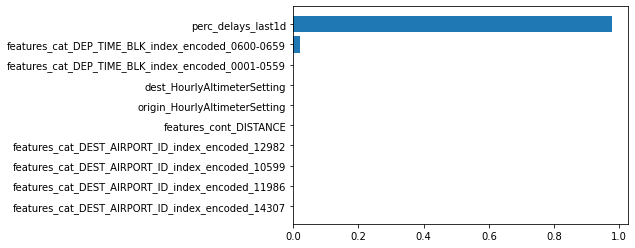

In [0]:
# Display decision tree
display(dt_c_model)

# Get Results
accuracy, precision, recall, f1score = evaluate_model(dt_c_predictions, 'c')
dt_c_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1score]})

# Print evaluation metrics
print('Accuracy: ', dt_c_results['Accuracy'][0])
print('Precision: ', dt_c_results['Precision'][0])
print('Recall: ', dt_c_results['Recall'][0])
print('F1 Score: ', dt_c_results['F1 Score'][0])
evaluator = BinaryClassificationEvaluator()
print("AUC: ", evaluator.evaluate(dt_c_predictions))

# Create df of feature importance
important_features = pd.DataFrame(dt_c_model.featureImportances.toArray()).reset_index()
important_features.columns.values[1] = 'feature_importance'
important_features = important_features.sort_values('feature_importance', ascending=False)
important_features = important_features.merge(feature_map, on='index')
important_features_filtered = important_features.head(10)
display(important_features)

# Plot top 10 important features 
x = important_features_filtered['name']
y = important_features_filtered['feature_importance']
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()

In [0]:
# Train model
dt_c_params =  { 'maxDepth': 5, 'impurity': 'gini', 'maxBins': 32, 'minInfoGain': 0 }
dt_c_full_results, dt_c_full_model = train_model_CV(train_cv_sample, model_type='DecisionTreeClassifier', params=dt_c_params)
display(dt_c_full_results)

# Save model 
basePath = "/tmp/HouseSpark/DecisionTreeClassifier_c_full"
dt_c_full_model.write().overwrite().save(basePath + "/model")

In [0]:
# Make predictions on test data 
basePath = "/tmp/HouseSpark/DecisionTreeClassifier_c_full"
dt_c_full_model = DecisionTreeClassificationModel.load(basePath + "/model")
dt_c_full_predictions = dt_c_full_model.transform(test_cv)

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-1215577238262468> in <cell line: 3>()
      1 # Make predictions on test data
      2 basePath = "/tmp/HouseSpark/DecisionTreeClassifier_c_full"
----> 3 dt_c_full_model = DecisionTreeClassificationModel.load(basePath + "/model")
      4 dt_c_full_predictions = dt_c_full_model.transform(test_cv)

/databricks/spark/python/pyspark/ml/util.py in load(cls, path)
    444     def load(cls, path: str) -> RL:
    445         """Reads an ML instance from the input path, a shortcut of `read().load(path)`."""
--> 446         return cls.read().load(path)
    447 
    448 

/databricks/spark/python/pyspark/ml/util.py in load(self, path)
    393         if not isinstance(path, str):
    394             raise TypeError("path should be a string, got type %s" % type(path))
--> 395         java_obj = self._jread.load(path)
    396         if not 

In [0]:
# Confusion Matrix 
TP = dt_c_full_predictions.where('label = 1').where('prediction = 1')
TN = dt_c_full_predictions.where('label = 0').where('prediction = 0')
FP = dt_c_full_predictions.where('label = 0').where('prediction = 1')
FN = dt_c_full_predictions.where('label = 1').where('prediction = 0')

confusion_matrix = pd.DataFrame(
  [['','Positive Prediction', 'Negative Prediction'],
   ['Positive Label', str(TP.count()), str(FN.count())],
   ['Negative Label', str(FP.count()), str(TN.count())]])

display(confusion_matrix)

In [0]:
# Display decision tree
display(dt_c_full_model)

# Get Results
accuracy, precision, recall, f1score = evaluate_model(dt_c_full_predictions, 'c')
dt_c_full_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1score]})

# Print evaluation metrics
print('Accuracy: ', dt_c_full_results['Accuracy'][0])
print('Precision: ', dt_c_full_results['Precision'][0])
print('Recall: ', dt_c_full_results['Recall'][0])
print('F1 Score: ', dt_c_full_results['F1 Score'][0])
evaluator = BinaryClassificationEvaluator()
print("AUC: ", evaluator.evaluate(dt_c_full_predictions))

# Create df of feature importance
important_features = pd.DataFrame(dt_c_full_model.featureImportances.toArray()).reset_index()
important_features.columns.values[1] = 'feature_importance'
important_features = important_features.sort_values('feature_importance', ascending=False)
important_features = important_features.merge(feature_map, on='index')
important_features_filtered = important_features.head(10)
display(important_features)

# Plot top 10 important features 
x = important_features_filtered['name']
y = important_features_filtered['feature_importance']
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()

#### Random Forest Classifier

In [0]:
# Train model
rf_c_params =  { 'maxDepth': 5, 'numTrees': 50, 'impurity': 'entropy', 'maxBins': 32, 'minInfoGain': 0 }
rf_c_results, rf_c_model = train_model_CV(train_cv_sample, model_type='RandomForestClassifier', params=rf_c_params)
display(rf_c_results)

# Save model 
basePath = "/tmp/HouseSpark/RandomForest_c"
rf_c_model.write().overwrite().save(basePath + "/model")

maxDepth,numTrees,impurity,maxBins,minInfoGain,Accuracy,Precision,Recall,F1 Score
5,50,entropy,32,0,0.732965446080936,0.8157444204948583,1.0,0.732965446080936
5,50,entropy,32,0,0.734017597056147,0.8164993937761013,1.0,0.734017597056147
5,50,entropy,32,0,0.8840780587037006,0.9216539808702681,1.0,0.8840780587037006


In [0]:
# Make predictions on test data 
basePath = "/tmp/HouseSpark/RandomForest_c"
rf_c_model = RandomForestClassificationModel.load(basePath + "/model")
rf_c_predictions = rf_c_model.transform(test_cv)

In [0]:
# Confusion Matrix 
TP = rf_c_predictions.where('label = 1').where('prediction = 1')
TN = rf_c_predictions.where('label = 0').where('prediction = 0')
FP = rf_c_predictions.where('label = 0').where('prediction = 1')
FN = rf_c_predictions.where('label = 1').where('prediction = 0')

confusion_matrix = pd.DataFrame(
  [['','Positive Prediction', 'Negative Prediction'],
   ['Positive Label', str(TP.count()), str(FN.count())],
   ['Negative Label', str(FP.count()), str(TN.count())]])

display(confusion_matrix)

0,1,2
,Positive Prediction,Negative Prediction
Positive Label,0,1022459
Negative Label,0,4868084


Accuracy:  0.7478834816604819
Precision:  0.8264236420988693
Recall:  1.0
F1 Score:  0.7478834816604819
AUC:  0.6744435331702908


index,feature_importance,name
139,0.08248470726046986,features_cat_DEP_TIME_BLK_index_encoded_0600-0659
28,0.06869928849266432,dest_HourlyRelativeHumidity
43,0.059165785489330686,perc_delays_last1d
14,0.0582761308125182,origin_HourlyWindSpeed
8,0.0490127944965979,origin_HourlySeaLevelPressure
154,0.04718398321781615,features_cat_DEP_TIME_BLK_index_encoded_2100-2159
10,0.04432121412542266,origin_HourlyVisibility
152,0.04294202933794735,features_cat_DEP_TIME_BLK_index_encoded_1900-1959
141,0.03835430589855458,features_cat_DEP_TIME_BLK_index_encoded_0800-0859
4,0.036307950606101556,origin_HourlyPrecipitation


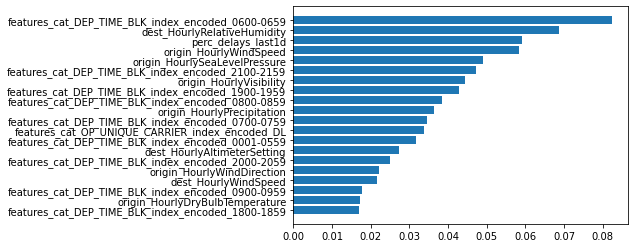

In [0]:
# Get Results
accuracy, precision, recall, f1score = evaluate_model(rf_c_predictions, 'c')
rf_c_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1score]})

# Print evaluation metrics
print('Accuracy: ', rf_c_results['Accuracy'][0])
print('Precision: ', rf_c_results['Precision'][0])
print('Recall: ', rf_c_results['Recall'][0])
print('F1 Score: ', rf_c_results['F1 Score'][0])
evaluator = BinaryClassificationEvaluator()
print("AUC: ", evaluator.evaluate(rf_c_predictions))

# Create df of feature importance
important_features = pd.DataFrame(rf_c_model.featureImportances.toArray()).reset_index()
important_features.columns.values[1] = 'feature_importance'
important_features = important_features.sort_values('feature_importance', ascending=False)
important_features = important_features.merge(feature_map, on='index')
important_features_filtered = important_features.head(20)
display(important_features)

# Plot top 10 important features 
x = important_features_filtered['name']
y = important_features_filtered['feature_importance']
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()

#### Neural Network

In [0]:
# Train model
nn_c_params = { 'maxIter': 5, 'stepSize': 0.09, 'blockSize': 300, 'tol': 0.00001, 'seed' : 1234, 'solver' : 'gd' }

nn_c_results, nn_c_model = train_model_CV(train_cv_sample, model_type='MultilayerPerceptronClassifier', params=nn_c_params)
display(nn_c_results)

# Save model 
basePath = "/tmp/HouseSpark/NeuralNetwork_c"
nn_c_model.write().overwrite().save(basePath + "/model")

maxIter,stepSize,blockSize,tol,seed,solver,Accuracy,Precision,Recall,F1 Score
5,0.09,300,1.0E-5,1234,gd,0.7336536826989718,0.81623829710826,1.0,0.7336536826989718
5,0.09,300,1.0E-5,1234,gd,0.7348739171138762,0.8171136467571382,1.0,0.7348739171138762
5,0.09,300,1.0E-5,1234,gd,0.8836394268786498,0.9213532007777145,1.0,0.8836394268786498


In [0]:
# Make predictions on test data 
basePath = "/tmp/HouseSpark/NeuralNetwork_c"
nn_c_model = MultilayerPerceptronClassificationModel.load(basePath + "/model")
nn_c_predictions = nn_c_model.transform(test_cv)

In [0]:
# Confusion Matrix 
TP = nn_c_predictions.where('label = 1').where('prediction = 1')
TN = nn_c_predictions.where('label = 0').where('prediction = 0')
FP = nn_c_predictions.where('label = 0').where('prediction = 1')
FN = nn_c_predictions.where('label = 1').where('prediction = 0')

confusion_matrix = pd.DataFrame(
  [['','Positive Prediction', 'Negative Prediction'],
   ['Positive Label', str(TP.count()), str(FN.count())],
   ['Negative Label', str(FP.count()), str(TN.count())]])

display(confusion_matrix)

0,1,2
,Positive Prediction,Negative Prediction
Positive Label,0,1022459
Negative Label,0,4868084


In [0]:
# Get Results
accuracy, precision, recall, f1score = evaluate_model(nn_c_predictions, 'c')
nn_c_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1score]})

# Print evaluation metrics
print('Accuracy: ', nn_c_results['Accuracy'][0])
print('Precision: ', nn_c_results['Precision'][0])
print('Recall: ', nn_c_results['Recall'][0])
print('F1 Score: ', nn_c_results['F1 Score'][0])
evaluator = BinaryClassificationEvaluator()
print("AUC: ", evaluator.evaluate(nn_c_predictions))

Accuracy:  0.7478834816604819
Precision:  0.8264236420988693
Recall:  1.0
F1 Score:  0.7478834816604819
AUC:  0.6734475489499357


### Regression

#### Linear Regression

In [0]:
# Train model
lin_reg_params = { 'maxIter': 20, 'regParam': 0.2, 'elasticNetParam': 0.8}
lin_reg_results, lin_reg_model = train_model_CV(train_cv_sample, model_type='LinearRegression', params=lin_reg_params)
display(lin_reg_results)

# Save model 
basePath = "/tmp/HouseSpark/LinearRegression_r"
lin_reg_model.write().overwrite().save(basePath + "/model")

maxIter,regParam,elasticNetParam,R2,RMSE,MSE,MAE
20,0.2,0.8,0.07078674244077476,39.2697172693791,1542.110694416971,16.48166512040105
20,0.2,0.8,0.06938773567355627,42.77182165537908,1829.428727719555,17.67686571959106
20,0.2,0.8,-0.024087155758969025,32.21808824864776,1038.005210397655,14.713335572751596


In [0]:
# Make predictions on test data 
basePath = "/tmp/HouseSpark/LinearRegression_r"
lin_reg_model = LinearRegressionModel.load(basePath + "/model")
lin_reg_predictions = lin_reg_model.transform(test_cv)

In [0]:
# Get Results
r2, rmse, mse, mae = evaluate_model(lin_reg_predictions, 'r')
lin_reg_results = pd.DataFrame({'R2': [r2], 'RMSE': [rmse], 'MSE': [mse], 'MAE': [mae]})

# Print evaluation metrics
print('R2: ', lin_reg_results['R2'][0])
print('RMSE: ', lin_reg_results['RMSE'][0])
print('MSE: ', lin_reg_results['MSE'][0])
print('MAE: ', lin_reg_results['MAE'][0])

# Display coefficients 
lin_reg_coef = pd.DataFrame(lin_reg_model.coefficients)
lin_reg_coef = lin_reg_coef.reset_index()
lin_reg_coef = lin_reg_coef.merge(feature_map, on='index')
display(lin_reg_coef)

R2:  0.033635435756791066
RMSE:  45.700064222041895
MSE:  2088.4982171180395
MAE:  18.07766424001644


index,0,name
0,0.006011557134867747,features_cont_DISTANCE
1,0.0,origin_HourlyAltimeterSetting
2,-0.024823657238187354,origin_HourlyDewPointTemperature
3,-0.08889175077438004,origin_HourlyDryBulbTemperature
4,0.0,origin_HourlyPrecipitation
5,0.08669433645001276,origin_HourlyPressureChange
6,0.07590561999768022,origin_HourlyPressureTendency
7,1.235206274436723,origin_HourlyRelativeHumidity
8,0.9839493795318,origin_HourlySeaLevelPressure
9,0.0,origin_HourlyStationPressure


## Top Performing Model Evaluation

#### Decision Tree Classifier

In [0]:
dt_c_predictions = dt_c_predictions.withColumn('true_pred', f.when((f.col('label') == (f.col('prediction')) ), 'yes').otherwise('no'))

pred_by_type = dt_c_predictions.groupby('type', 'true_pred').count()
display(pred_by_type)

type,true_pred,count
medium_airport,no,197003
medium_airport,yes,966887
large_airport,no,840439
large_airport,yes,3866252
small_airport,yes,16760
small_airport,no,3202


Output can only be rendered in Databricks

In [0]:
dt_c_predictions = dt_c_predictions.withColumn('delay_reason', 
                                               when((f.col('CARRIER_DELAY') > 0), 'carrier')\
                                               .when((f.col('WEATHER_DELAY') > 0), 'weather')\
                                               .when((f.col('NAS_DELAY') > 0), 'nas')\
                                               .when((f.col('SECURITY_DELAY') > 0), 'security')\
                                               .when((f.col('LATE_AIRCRAFT_DELAY') > 0), 'late_aircraft')\
                                               .otherwise('no_delay'))

pred_by_delay_reason = dt_c_predictions.groupby('delay_reason', 'true_pred').count()
display(pred_by_delay_reason)

delay_reason,true_pred,count
weather,no,53296
late_aircraft,no,110846
nas,yes,8527
weather,yes,3605
carrier,no,455108
nas,no,78177
carrier,yes,65019
no_delay,yes,4761611
security,no,3377
no_delay,no,339832


Output can only be rendered in Databricks

In [0]:
pred_by_origin_state = dt_c_predictions.groupby('ORIGIN_STATE_ABR', 'true_pred').count()
display(pred_by_origin_state)

ORIGIN_STATE_ABR,true_pred,count
PR,yes,23954
ID,no,4079
NE,no,3604
VA,no,25511
ND,yes,14248
ND,no,2585
PA,no,18458
AZ,no,36462
KY,yes,48920
NH,yes,4287


Output can only be rendered in Databricks

In [0]:
pred_by_dest_state = dt_c_predictions.groupby('DEST_STATE_ABR', 'true_pred').count()
display(pred_by_dest_state)

DEST_STATE_ABR,true_pred,count
ID,no,5362
NJ,yes,74284
FL,no,114165
VA,no,26714
MA,yes,74677
UT,no,16223
NY,no,39781
NJ,no,18084
MD,yes,57150
NV,yes,125141


Output can only be rendered in Databricks

In [0]:
pred_by_month = dt_c_predictions.groupby('MONTH', 'true_pred').count()
display(pred_by_month)

MONTH,true_pred,count
1,yes,327117
1,no,30607
5,yes,424966
2,no,39740
6,yes,404537
9,yes,455673
4,no,48324
10,no,108013
7,yes,425748
10,yes,445011


Output can only be rendered in Databricks

In [0]:
pred_by_dow = dt_c_predictions.groupby('DAY_OF_WEEK', 'true_pred').count()
display(pred_by_dow)

DAY_OF_WEEK,true_pred,count
1,yes,711439
1,no,160583
5,yes,726876
2,no,124941
6,yes,644527
4,no,156047
7,yes,701733
6,no,140899
3,yes,677735
5,no,163045


Output can only be rendered in Databricks

Out[21]: <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fbd4833bd60>

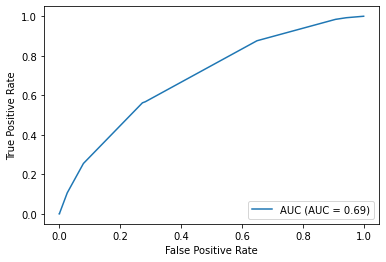

In [0]:
# ROC Curve
from sklearn import metrics
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, RocCurveDisplay

preds = dt_c_predictions.select('label','probability')\
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))\
    .collect()

y_score, y_true = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='AUC')
display.plot()